In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
INTERACTIONS = 'data/9606.protein.links.full.v11.5.txt'
PROTEINS = 'data/9606.protein.info.v11.5.txt'
KINHUB_KINOME = 'data/kinhub_kinome.csv'
UNIPROT_KINOME = 'data/uniprot_kinome.csv'

In [3]:
p_df = pd.read_csv(PROTEINS, sep='\t', index_col=0)
p_df.preferred_name = p_df.preferred_name.str.lower()
p_df['ensembl_id'] = p_df.index
p_df['idx'] = np.arange(len(p_df.index))
p_df = p_df.set_index('idx')
p_df['idx'] = p_df.index
p_df.head()

,preferred_name,protein_size,annotation,ensembl_id,idx
idx,,,,,
0,arf5,180,ADP-ribosylation factor 5; GTP-binding protein...,9606.ENSP00000000233,0
1,m6pr,277,Cation-dependent mannose-6-phosphate receptor;...,9606.ENSP00000000412,1
2,fkbp4,459,Peptidyl-prolyl cis-trans isomerase FKBP4; Imm...,9606.ENSP00000001008,2
3,cyp26b1,512,Cytochrome P450 26B1; Involved in the metaboli...,9606.ENSP00000001146,3
4,ndufaf7,441,"Protein arginine methyltransferase NDUFAF7, mi...",9606.ENSP00000002125,4


## Filter kinases

In [4]:
def parse_uniprot_response(response):
    from io import StringIO
    return pd.read_csv(StringIO(response), sep='\t')
    

def uniprot_convert(ids, format_from, format_to):
    import urllib.parse
    import urllib.request

    url = 'https://www.uniprot.org/uploadlists/'
    query = ' '.join(ids)
    
    params = {
    'from': format_from,
    'to': format_to,
    'format': 'tab',
    'query': query
    }

    data = urllib.parse.urlencode(params)
    data = data.encode('utf-8')
    req = urllib.request.Request(url, data)
    with urllib.request.urlopen(req) as f:
        response = f.read()
        response = response.decode('utf-8')
        return parse_uniprot_response(response)

def uniprot_to_ensembl(uniprot_ids):
    t = uniprot_convert(uniprot_ids, format_from='ACC+ID', format_to='ENSEMBL_PRO_ID')
    t['To'] = '9606.' + t.To
    return t

def ensembl_gene_to_prot(ensembl_gene_ids):
    uniprot_ids = uniprot_convert(ensembl_gene_ids, format_from='ENSEMBL_ID', format_to='ACC')
    return uniprot_to_ensembl(uniprot_ids['To'])

In [5]:
# kinases retreved from uniprot
k_df = pd.read_csv(UNIPROT_KINOME, sep='\t', index_col=0)
k_uniprot_ids = k_df.index
k_ens_ids = uniprot_to_ensembl(k_uniprot_ids)['To']

In [6]:
# kinases retrieved from kinhub
k_df = pd.read_csv(KINHUB_KINOME, sep='\t', header=None)
k_df.columns = ['Name', 'Manning Name', 'HGNC Name', 'Kinase Name', 'Group', 'Family', 'SubFamily', 'UniprotID']
k_df = k_df.set_index('UniprotID')
k_uniprot_ids = k_df.index
k_ens_ids = uniprot_to_ensembl(k_uniprot_ids)['To']

In [7]:
i_df = pd.read_csv(INTERACTIONS, sep=' ')

In [8]:
i_df.columns

Index(['protein1', 'protein2', 'neighborhood', 'neighborhood_transferred',
       'fusion', 'cooccurence', 'homology', 'coexpression',
       'coexpression_transferred', 'experiments', 'experiments_transferred',
       'database', 'database_transferred', 'textmining',
       'textmining_transferred', 'combined_score'],
      dtype='object')

<AxesSubplot:>

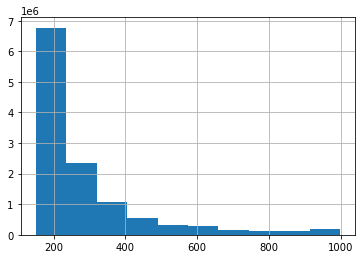

In [9]:
i_df.combined_score.hist()

In [10]:
def get_ids(prots):
    return p_df[p_df.preferred_name.isin(prots)].index

def get_id(prot):
    prot_id = p_df[p_df.preferred_name == prot].index
    assert len(prot_id) == 1
    return prot_id[0]

def get_ens_id(prot):
    ens_id = p_df[p_df.preferred_name == prot].ensembl_id
    assert len(ens_id) == 1
    return ens_id.iloc[0]

In [11]:
def select_high_confidence(i_df, score_threshold=600):
    f_i_df = i_df[(i_df['combined_score'] > score_threshold)][['protein1', 'protein2']]
    ## add protein names
    f_i_df = f_i_df.join(p_df.set_index('ensembl_id')[['preferred_name', 'idx']], on='protein1', rsuffix='1')\
        .join(p_df.set_index('ensembl_id')[['preferred_name', 'idx']], on='protein2', rsuffix='2')
    f_i_df = f_i_df.rename(columns={'preferred_name': 'preferred_name1', 'idx': 'idx1'})
    return f_i_df

def select_proteins(i_df, proteins):
    return i_df[(i_df.protein1.isin(proteins) & i_df.protein2.isin(proteins))]

f_i_df = select_high_confidence(i_df)
f_i_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 782396 entries, 5 to 11938267
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   protein1         782396 non-null  object
 1   protein2         782396 non-null  object
 2   preferred_name1  782396 non-null  object
 3   idx1             782396 non-null  int64 
 4   preferred_name2  782396 non-null  object
 5   idx2             782396 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 41.8+ MB


In [12]:
target_proteins = set(k_ens_ids).union({get_ens_id('tp53')})
f_i_df = select_proteins(f_i_df, target_proteins)
f_i_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4856 entries, 11890 to 11860016
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   protein1         4856 non-null   object
 1   protein2         4856 non-null   object
 2   preferred_name1  4856 non-null   object
 3   idx1             4856 non-null   int64 
 4   preferred_name2  4856 non-null   object
 5   idx2             4856 non-null   int64 
dtypes: int64(2), object(4)
memory usage: 265.6+ KB


some stats:

In [13]:
f_i_df.groupby('idx1').size().median()

7.0

## Impose directionality

In [64]:
d_ks = pd.read_csv('data/phosphosite_kinase_substrate.csv', sep='\t')
d_ks = d_ks[(d_ks.KIN_ORGANISM == 'human') & (d_ks.SUB_ORGANISM == 'human')]
d_ks['KIN_ACC_ID'] = d_ks.KIN_ACC_ID.astype(str)
d_ks['SUB_ACC_ID'] = d_ks.SUB_ACC_ID.astype(str)
d_ks.head()

,GENE,KINASE,KIN_ACC_ID,KIN_ORGANISM,SUBSTRATE,SUB_GENE_ID,SUB_ACC_ID,SUB_GENE,SUB_ORGANISM,SUB_MOD_RSD,SITE_GRP_ID,SITE_+/-7_AA,DOMAIN,IN_VIVO_RXN,IN_VITRO_RXN,CST_CAT#
7,EIF2AK1,HRI,Q9BQI3,human,eIF2-alpha,1965.0,P05198,EIF2S1,human,S52,447635,MILLsELsRRRIRsI,S1,,X,3597; 9721; 3398; 5199; 53085
8,EIF2AK1,HRI,Q9BQI3,human,eIF2-alpha,1965.0,P05198,EIF2S1,human,S49,450210,IEGMILLsELsRRRI,S1,,X,NaN
11,PRKCD,PKCD,Q05655,human,HDAC5,10014.0,Q9UQL6,HDAC5,human,S259,447995,FPLRkTAsEPNLKVR,NaN,,X,3443
12,PRKCD,PKCD,Q05655,human,PTPRA iso2,5786.0,P18433-2,PTPRA,human,S204,447612,PLLARSPsTNRKYPP,NaN,X,,NaN
13,PRKCD,PKCD,Q05655,human,Bcl-2,596.0,P10415,BCL2,human,S70,448395,RDPVARtsPLQtPAA,NaN,X,,2834; 2827


In [66]:
d_ks[(d_ks.SUB_GENE=='RAF1') & (d_ks.SUB_ORGANISM == 'human')]

,GENE,KINASE,KIN_ACC_ID,KIN_ORGANISM,SUBSTRATE,SUB_GENE_ID,SUB_ACC_ID,SUB_GENE,SUB_ORGANISM,SUB_MOD_RSD,SITE_GRP_ID,SITE_+/-7_AA,DOMAIN,IN_VIVO_RXN,IN_VITRO_RXN,CST_CAT#
1447,LATS1,LATS1,O95835,human,RAF1,5894.0,P04049,RAF1,human,S259,447741,sQRQRststPNVHMV,NaN,,X,9421
2695,RAF1,RAF1,P04049,human,RAF1,5894.0,P04049,RAF1,human,S621,447746,PKINRsAsEPsLHRA,NaN,X,X,NaN
2704,RAF1,RAF1,P04049,human,RAF1,5894.0,P04049,RAF1,human,S359,28070702,StRIGsGsFGtVYkG,Pkinase_Tyr,X,,NaN
2708,RAF1,RAF1,P04049,human,RAF1,5894.0,P04049,RAF1,human,S259,447741,sQRQRststPNVHMV,NaN,X,,9421
2710,RAF1,RAF1,P04049,human,RAF1,5894.0,P04049,RAF1,human,S338,447742,RPRGQRDssyyWEIE,NaN,X,,9427
3617,PRKACA,PKACA,P17612,human,RAF1,5894.0,P04049,RAF1,human,S259,447741,sQRQRststPNVHMV,NaN,,X,9421
3798,PRKACA,PKACA,P17612,human,RAF1,5894.0,P04049,RAF1,human,S621,447746,PKINRsAsEPsLHRA,NaN,,X,NaN
3964,PRKACA,PKACA,P17612,human,RAF1,5894.0,P04049,RAF1,human,S43,447744,FGyQRRAsDDGKLtD,NaN,,X,NaN
4359,MAPK3,ERK1,P27361,human,RAF1,5894.0,P04049,RAF1,human,S301,455219,sssPNNLsPtGWsQP,NaN,X,X,9431
4608,MAPK3,ERK1,P27361,human,RAF1,5894.0,P04049,RAF1,human,S289,455311,RsHsEsAsPsALsss,NaN,X,X,9431


In [15]:
d_ks.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13273 entries, 7 to 21825
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   GENE          13273 non-null  object 
 1   KINASE        13273 non-null  object 
 2   KIN_ACC_ID    13273 non-null  object 
 3   KIN_ORGANISM  13273 non-null  object 
 4   SUBSTRATE     13273 non-null  object 
 5   SUB_GENE_ID   13271 non-null  float64
 6   SUB_ACC_ID    13273 non-null  object 
 7   SUB_GENE      13273 non-null  object 
 8   SUB_ORGANISM  13273 non-null  object 
 9   SUB_MOD_RSD   13273 non-null  object 
 10  SITE_GRP_ID   13273 non-null  int64  
 11  SITE_+/-7_AA  13273 non-null  object 
 12  DOMAIN        4811 non-null   object 
 13  IN_VIVO_RXN   13273 non-null  object 
 14  IN_VITRO_RXN  13273 non-null  object 
 15  CST_CAT#      1834 non-null   object 
dtypes: float64(1), int64(1), object(14)
memory usage: 1.7+ MB


In [16]:
kin_ens_ids = uniprot_to_ensembl(d_ks.KIN_ACC_ID)
sub_ens_ids = uniprot_to_ensembl(d_ks.SUB_ACC_ID)

In [17]:
kin_ens_ids = kin_ens_ids.set_index('From').rename(columns={'To': 'kin_ens_id'})
sub_ens_ids = sub_ens_ids.set_index('From').rename(columns={'To': 'sub_ens_id'})

In [18]:
kin_ens_ids.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1260 entries, Q9BQI3 to Q8IYT8
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   kin_ens_id  1260 non-null   object
dtypes: object(1)
memory usage: 19.7+ KB


In [19]:
d_ks = d_ks.join(kin_ens_ids, on='KIN_ACC_ID').join(sub_ens_ids, on='SUB_ACC_ID')

In [21]:
backwards_edges = pd.merge(f_i_df, d_ks, left_on=['protein1', 'protein2'], right_on=['sub_ens_id', 'kin_ens_id'], how='inner')[f_i_df.columns]
backwards_edges.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 703 entries, 0 to 702
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   protein1         703 non-null    object
 1   protein2         703 non-null    object
 2   preferred_name1  703 non-null    object
 3   idx1             703 non-null    int64 
 4   preferred_name2  703 non-null    object
 5   idx2             703 non-null    int64 
dtypes: int64(2), object(4)
memory usage: 38.4+ KB


In [23]:
d_i_df = f_i_df.append(backwards_edges).drop_duplicates(keep=False)
d_i_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4480 entries, 11890 to 11859905
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   protein1         4480 non-null   object
 1   protein2         4480 non-null   object
 2   preferred_name1  4480 non-null   object
 3   idx1             4480 non-null   int64 
 4   preferred_name2  4480 non-null   object
 5   idx2             4480 non-null   int64 
dtypes: int64(2), object(4)
memory usage: 245.0+ KB


In [63]:
d_ks[(d_ks.SUB_GENE=='AKT1') & (d_ks.SUB_ORGANISM == 'human')]

,GENE,KINASE,KIN_ACC_ID,KIN_ORGANISM,SUBSTRATE,SUB_GENE_ID,SUB_ACC_ID,SUB_GENE,SUB_ORGANISM,SUB_MOD_RSD,SITE_GRP_ID,SITE_+/-7_AA,DOMAIN,IN_VIVO_RXN,IN_VITRO_RXN,CST_CAT#,kin_ens_id,sub_ens_id
727,CSNK2A1,CK2A1,P68400,human,Akt1,207.0,P31749,AKT1,human,S129,450019,sGsPsDNsGAEEMEV,NaN,X,X,13461,9606.ENSP00000217244,9606.ENSP00000270202
727,CSNK2A1,CK2A1,P68400,human,Akt1,207.0,P31749,AKT1,human,S129,450019,sGsPsDNsGAEEMEV,NaN,X,X,13461,9606.ENSP00000217244,9606.ENSP00000385326
727,CSNK2A1,CK2A1,P68400,human,Akt1,207.0,P31749,AKT1,human,S129,450019,sGsPsDNsGAEEMEV,NaN,X,X,13461,9606.ENSP00000217244,9606.ENSP00000384293
727,CSNK2A1,CK2A1,P68400,human,Akt1,207.0,P31749,AKT1,human,S129,450019,sGsPsDNsGAEEMEV,NaN,X,X,13461,9606.ENSP00000217244,9606.ENSP00000451828
727,CSNK2A1,CK2A1,P68400,human,Akt1,207.0,P31749,AKT1,human,S129,450019,sGsPsDNsGAEEMEV,NaN,X,X,13461,9606.ENSP00000217244,9606.ENSP00000451166
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21109,RET,Ret,P07949,human,Akt1,207.0,P31749,AKT1,human,Y315,448519,tFCGtPEyLAPEVLE,Pkinase,X,X,NaN,9606.ENSP00000347942,9606.ENSP00000451828
21109,RET,Ret,P07949,human,Akt1,207.0,P31749,AKT1,human,Y315,448519,tFCGtPEyLAPEVLE,Pkinase,X,X,NaN,9606.ENSP00000347942,9606.ENSP00000451166
21109,RET,Ret,P07949,human,Akt1,207.0,P31749,AKT1,human,Y315,448519,tFCGtPEyLAPEVLE,Pkinase,X,X,NaN,9606.ENSP00000347942,9606.ENSP00000450688
21109,RET,Ret,P07949,human,Akt1,207.0,P31749,AKT1,human,Y315,448519,tFCGtPEyLAPEVLE,Pkinase,X,X,NaN,9606.ENSP00000347942,9606.ENSP00000497822


In [55]:
d_ks.head()

,GENE,KINASE,KIN_ACC_ID,KIN_ORGANISM,SUBSTRATE,SUB_GENE_ID,SUB_ACC_ID,SUB_GENE,SUB_ORGANISM,SUB_MOD_RSD,SITE_GRP_ID,SITE_+/-7_AA,DOMAIN,IN_VIVO_RXN,IN_VITRO_RXN,CST_CAT#,kin_ens_id,sub_ens_id
7,EIF2AK1,HRI,Q9BQI3,human,eIF2-alpha,1965.0,P05198,EIF2S1,human,S52,447635,MILLsELsRRRIRsI,S1,,X,3597; 9721; 3398; 5199; 53085,9606.ENSP00000199389,9606.ENSP00000256383
7,EIF2AK1,HRI,Q9BQI3,human,eIF2-alpha,1965.0,P05198,EIF2S1,human,S52,447635,MILLsELsRRRIRsI,S1,,X,3597; 9721; 3398; 5199; 53085,9606.ENSP00000199389,9606.ENSP00000425299
8,EIF2AK1,HRI,Q9BQI3,human,eIF2-alpha,1965.0,P05198,EIF2S1,human,S49,450210,IEGMILLsELsRRRI,S1,,X,NaN,9606.ENSP00000199389,9606.ENSP00000256383
8,EIF2AK1,HRI,Q9BQI3,human,eIF2-alpha,1965.0,P05198,EIF2S1,human,S49,450210,IEGMILLsELsRRRI,S1,,X,NaN,9606.ENSP00000199389,9606.ENSP00000425299
11,PRKCD,PKCD,Q05655,human,HDAC5,10014.0,Q9UQL6,HDAC5,human,S259,447995,FPLRkTAsEPNLKVR,NaN,,X,3443,9606.ENSP00000331602,9606.ENSP00000225983


## Contruct all pathways between proteins

In [25]:
import networkx as nx

In [26]:
taok1 = get_id('taok1')
p53 = get_id('tp53')
mst1 = get_id('stk4')
mst2 = get_id('stk3')
map2k3 = get_id('map2k3')
map4k4 = get_id('map4k4')
raf1 = get_id('raf1')
lats1 = get_id('lats1')
chek1 = get_id('chek1')
chek2 = get_id('chek2')
akt1 = get_id('akt1')
lats2 = get_id('lats2')

In [27]:
mst1

11484

In [28]:
g = nx.from_pandas_edgelist(d_i_df, 'idx1', 'idx2', create_using=nx.DiGraph())


In [29]:
def find_paths(graph, nodes_from, nodes_to, max_len, ignore_nodes={}):
    import queue
    cands = queue.Queue()
    for n in nodes_from: 
        cands.put([n])
    paths = []
    max_queue_size = 0
    while not cands.empty():
        max_queue_size = max(cands.qsize(), max_queue_size)
        cand = cands.get()
        last_node = cand[-1]
        for next_node in graph[last_node]:
            if next_node in cand:
                continue
            if next_node in ignore_nodes:
                continue
            next_path = cand + [next_node]
            if next_node in nodes_to:
                paths.append(next_path)
                continue
            if len(next_path) == max_len:
                continue
            cands.put(next_path)
    print('max queue size: ', max_queue_size)
    return paths

def print_pathway(p):
    return '--> '.join([p_df.loc[n].preferred_name for n in p])

In [30]:
p_mst_p53 = find_paths(g, [mst1, mst2], {p53}, max_len=4, ignore_nodes={raf1})
print('Found pathways: ', len(p_mst_p53))

max queue size:  41
Found pathways:  31


In [36]:
p_taok_mst = find_paths(g, [taok1], {mst1, mst2}, max_len=5,
                        ignore_nodes={p53})
                        #ignore_nodes={akt1, chek1, raf1, chek2, 
                        #              p53, lats1, lats2})
print('Found pathways: ', len(p_taok_mst))

max queue size:  1812
Found pathways:  42


In [33]:
p_taok_mst = find_paths(g, [taok1], {mst1, mst2}, max_len=9, 
                        ignore_nodes={akt1, chek1, raf1, chek2, 
                                      p53, lats1, lats2})
print('Found pathways: ', len(p_taok_mst))

NameError: name 'chk1' is not defined

In [37]:
for p in p_taok_mst:
    print(print_pathway(p))

taok1--> taok2--> atm--> akt1--> stk3
taok1--> taok2--> atm--> chek2--> stk4
taok1--> taok2--> atm--> chek2--> stk3
taok1--> map2k3--> mapk8--> akt1--> stk3
taok1--> map2k3--> mapk9--> akt1--> stk3
taok1--> map2k3--> mapkapk2--> akt1--> stk3
taok1--> map2k3--> mapk3--> raf1--> stk3
taok1--> map2k3--> mapk3--> akt1--> stk3
taok1--> map2k3--> mapk3--> chek2--> stk4
taok1--> map2k3--> mapk3--> chek2--> stk3
taok1--> map2k3--> mapk12--> akt1--> stk3
taok1--> map2k3--> mapk13--> akt1--> stk3
taok1--> map2k3--> pak1--> akt1--> stk3
taok1--> map2k3--> pak1--> raf1--> stk3
taok1--> map2k3--> mapk14--> akt1--> stk3
taok1--> map2k3--> mapk11--> akt1--> stk3
taok1--> map2k3--> src--> raf1--> stk3
taok1--> map2k3--> src--> akt1--> stk3
taok1--> map2k3--> mapk1--> raf1--> stk3
taok1--> map2k3--> mapk1--> akt1--> stk3
taok1--> map2k3--> mapk1--> chek2--> stk4
taok1--> map2k3--> mapk1--> chek2--> stk3
taok1--> map2k6--> prkaca--> raf1--> stk3
taok1--> map2k6--> mapk13--> akt1--> stk3
taok1--> map2k6-

In [38]:
for p in p_mst_p53:
    print(print_pathway(p))

stk4--> tp53
stk4--> chek2--> tp53
stk4--> lats2--> tp53
stk3--> chek2--> tp53
stk3--> stk4--> tp53
stk3--> lats2--> tp53
stk4--> lats1--> lats2--> tp53
stk4--> stk3--> chek2--> tp53
stk4--> stk3--> lats2--> tp53
stk4--> chek2--> plk2--> tp53
stk4--> chek2--> chek1--> tp53
stk4--> chek2--> bub1--> tp53
stk4--> chek2--> mtor--> tp53
stk4--> chek2--> bub1b--> tp53
stk4--> chek2--> mapk3--> tp53
stk4--> chek2--> mapk1--> tp53
stk4--> chek2--> wee1--> tp53
stk3--> chek2--> plk2--> tp53
stk3--> chek2--> stk4--> tp53
stk3--> chek2--> chek1--> tp53
stk3--> chek2--> bub1--> tp53
stk3--> chek2--> mtor--> tp53
stk3--> chek2--> bub1b--> tp53
stk3--> chek2--> mapk3--> tp53
stk3--> chek2--> mapk1--> tp53
stk3--> chek2--> wee1--> tp53
stk3--> stk4--> chek2--> tp53
stk3--> stk4--> lats2--> tp53
stk3--> lats2--> stk4--> tp53
stk3--> lats1--> lats2--> tp53
stk3--> lats1--> stk4--> tp53


In [39]:
def pathways_genes(pathways):
    import itertools
    return set(itertools.chain.from_iterable(pathways))
common = pathways_genes(p_taok_mst).intersection(pathways_genes(p_mst_p53))
[p_df.loc[n].preferred_name for n in common]

['chek2', 'stk3', 'mapk3', 'mapk1', 'stk4']

## Filter active genes

In [40]:
active_genes = pd.read_csv('data/zgn_active_genes.csv', sep=' ')['x']
active_genes.head()

1    ENSG00000227232
2    ENSG00000279457
3    ENSG00000225972
4    ENSG00000225630
5    ENSG00000237973
Name: x, dtype: object

In [41]:
active_prots = ensembl_gene_to_prot(active_genes)['To']

In [42]:
active_targets = set(active_prots).intersection(target_proteins)
len(target_proteins), len(active_targets)

(1561, 1050)

In [43]:
active_targets_ids = p_df[p_df.ensembl_id.isin(active_targets)].index

In [44]:
def to_percentage(x):
    return int(round(x * 100))

def activity_score(pathway, active_ids=active_targets_ids):
    num_active_nodes = sum([1 if n in active_ids else 0 for n in pathway])
    num_nodes = len(pathway)
    score = to_percentage(num_active_nodes / num_nodes)
    return score

def filter_active(pathways, min_activity_score = 80):
    return [p for p in pathways if activity_score(p) >= min_activity_score]

In [45]:
len(p_mst_p53), len(filter_active(p_mst_p53))

(31, 31)

## Construct graph and visualize

In [46]:
from nxpd import draw
from nxpd import nxpdParams
nxpdParams['show'] = 'ipynb'

In [47]:
def gen_edges(p):
    return [(p[i], p[i+1]) for i in range(len(p)-1)]

def draw_pathways(pp, golden_nodes):
    import os
    # importing issue fix: https://datascience.stackexchange.com/questions/37428/graphviz-not-working-when-imported-inside-pydotplus-graphvizs-executables-not
    #os.environ['PATH'] = os.environ['PATH']+';'+os.environ['CONDA_PREFIX']+r"\Library\bin\graphviz"
    import itertools
    g = nx.DiGraph()
    for p in pp:
        #g.add_nodes_from(p)
        g.add_edges_from(gen_edges(p))
        
    nodes = set(itertools.chain(g))
    names = {n: {
        'label': p_df.loc[n].preferred_name,
        'color': 'green' if n in golden_nodes else 'black'
    } for n in nodes}
    nx.set_node_attributes(g, names)
    g.number_of_selfloops = lambda : 0

    return g

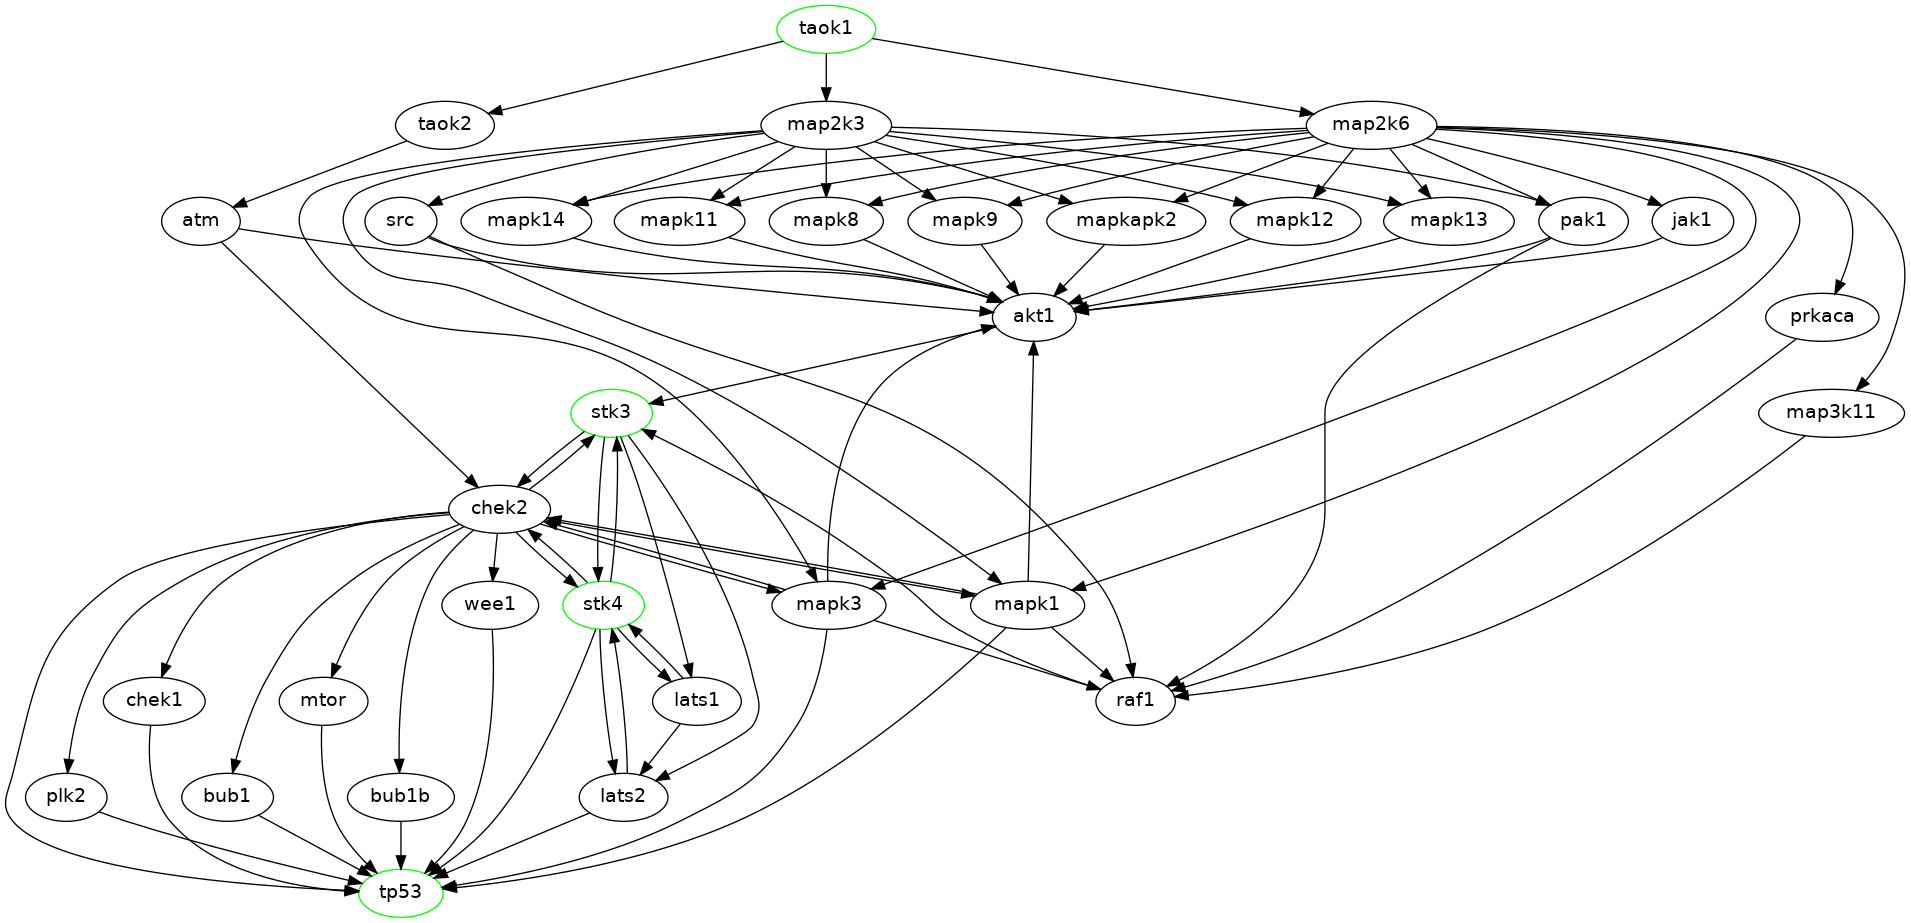

In [48]:
active_only = False
pathways = p_taok_mst+p_mst_p53
if active_only:
    pathways = filter_active(pathways)
draw(draw_pathways(pathways, {taok1, mst1, mst2, p53}))

In [49]:
len(pathways)

73

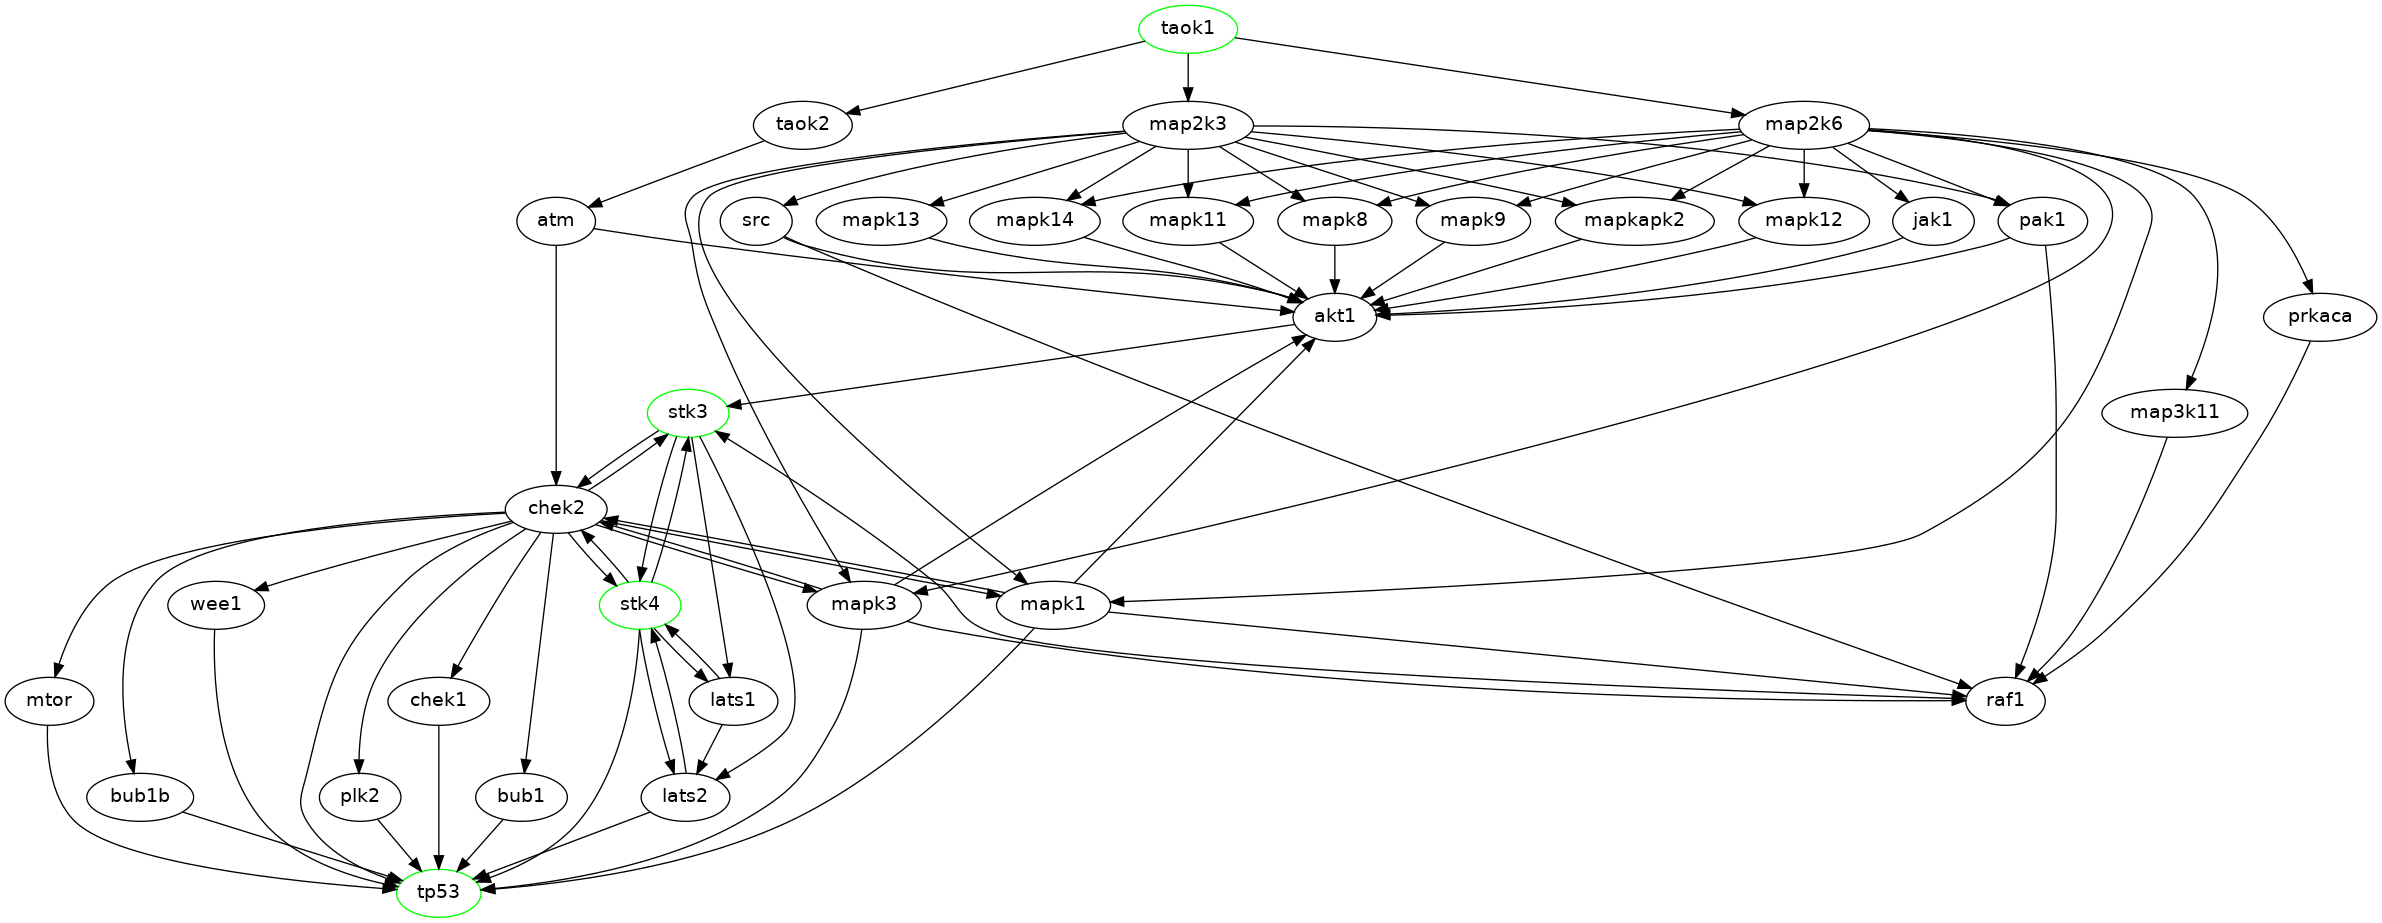

In [50]:
active_only = True
pathways = p_taok_mst+p_mst_p53
if active_only:
    pathways = filter_active(pathways)
draw(draw_pathways(pathways, {taok1, mst1, mst2, p53}))